## Ski Rental with Movie Lens
This notebook trains predictors for whether a user will watch more than b movies in the next month. 
We use these raw and calibrated predictors to compare the results of the ski-rental algorithms we propose in our paper.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() 
# features
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# models 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge, LinearRegression
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor
from sklearn.kernel_ridge import KernelRidge

#calibration library
from crepes import WrapRegressor

# metrics
from sklearn.metrics import roc_auc_score
from sklearn import tree

import models as md
import utils as ut
import calibrator as cal
import skirental as sr

%load_ext autoreload 
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Section 0: Loading Data

In [2]:
movie_df = pd.read_csv('clean_data/movie_lens100k_monthly.csv')

In [12]:
b = 5
y = movie_df['movies_this_month'].values
# Transform both feature sets
X_clf = movie_df[['age', 'gender', 'occupation', 'zip', 'movies_watched']]
X_reg = movie_df[['age', 'gender', 'movies_watched']]

# Create separate DictVectorizers for each feature set
vec_clf = DictVectorizer()
vec_reg = DictVectorizer()

X_post_clf = vec_clf.fit_transform(X_clf.to_dict('records')).toarray()
X_post_reg = vec_reg.fit_transform(X_reg.to_dict('records')).toarray()

### Section 1: Training & Calibrating Predictors

In [6]:
# training calibrated regression model: 
i=1
X_train, X_test, y_train, y_test = train_test_split(
    X_post_reg, y, test_size=0.20, random_state=i)

X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train, test_size=0.20, random_state=i)

print(f"size train: {len(X_train)}, valid: {len(X_valid)} test: {len(X_test)} ")
model = Pipeline(
            [
                ("scalar", StandardScaler()),
                #("LR", LinearRegression()), #0.002
                #("BR", BayesianRidge()) #0.06
                #("xgb", XGBRegressor()), # -0.11
                #("kernel", KernelRidge()), #-0.16
                #("SVR", SVR()), # -0.08 
                ("sgd", SGDRegressor()) # 0.07
                #("en", ElasticNet()) 0.05
                #("RFR", RandomForestRegressor()), 0.03
            ]
        )

# regular pred: 
model.fit(X_train, y_train)
print(model.score(X_test, y_test))
rf = WrapRegressor(model)
rf.fit(X_train, y_train)
rf.calibrate(X_valid, y_valid)
conf_interval = rf.predict_int(X_test, confidence=0.7)

size train: 346, valid: 87 test: 109 
0.06940344173714974


In [8]:
clf_list = ['LR', 'GB', 'XGB', 'KNN', 'RF']
training_results = [] 
num_runs = 1
binary_clfs = {} 
calibrators = {} 
bins = 10 
for i in range(num_runs): 
        X_train, X_test, y_train, y_test = train_test_split(
            X_post_clf, y>b, test_size=0.20, random_state=i)

        X_train, X_valid, y_train, y_valid = train_test_split(
                X_train, y_train, test_size=0.20, random_state=i)

        for name in clf_list: 
            curr_clf = md.model_choice(name, X_train, y_train)
            curr_clf.fit(X_train, y_train)
            probs = curr_clf.predict_proba(X_test)[:, 1]
            _, _, ece_l1, ece_l2 = ut.expected_calibration_error(prob_true=np.asarray(y_test), 
                                                                 prob_pred=np.asarray(probs), 
                                                                 num_bins=bins)
            training_results.append({
                'clf': name, 
                'run': i, 
                'b': b, 
                'ece_l1': ece_l1, 
                'ece_l2': ece_l2, 
                'accuracy': curr_clf.score(X_test, y_test), 
                'auc': roc_auc_score(y_test, probs),
                'calibrated': False
            })
            binary_clfs[name] = curr_clf

            calibrator = cal.BinningCalibrator(bins=bins)
            calibrator.calibrate(curr_clf.predict_proba(X_valid)[:, 1], y_valid)
            y_cal_probs = calibrator.transform(probs)
            _, _, ece_l1, ece_l2 = ut.expected_calibration_error(prob_true=np.asarray(y_test),
                                                                 prob_pred=np.asarray(y_cal_probs),
                                                                 num_bins=bins)
            training_results.append({
                'clf': name, 
                'run': i, 
                'b': b, 
                'ece_l1': ece_l1, 
                'ece_l2': ece_l2, 
                'accuracy': ((y_cal_probs > 0.5) ==  y_test).mean(), 
                'auc': roc_auc_score(y_test, y_cal_probs),
                'calibrated': True
            })
            calibrators[name] = calibrator

running model search


In [9]:
training_results_df = pd.DataFrame(training_results)

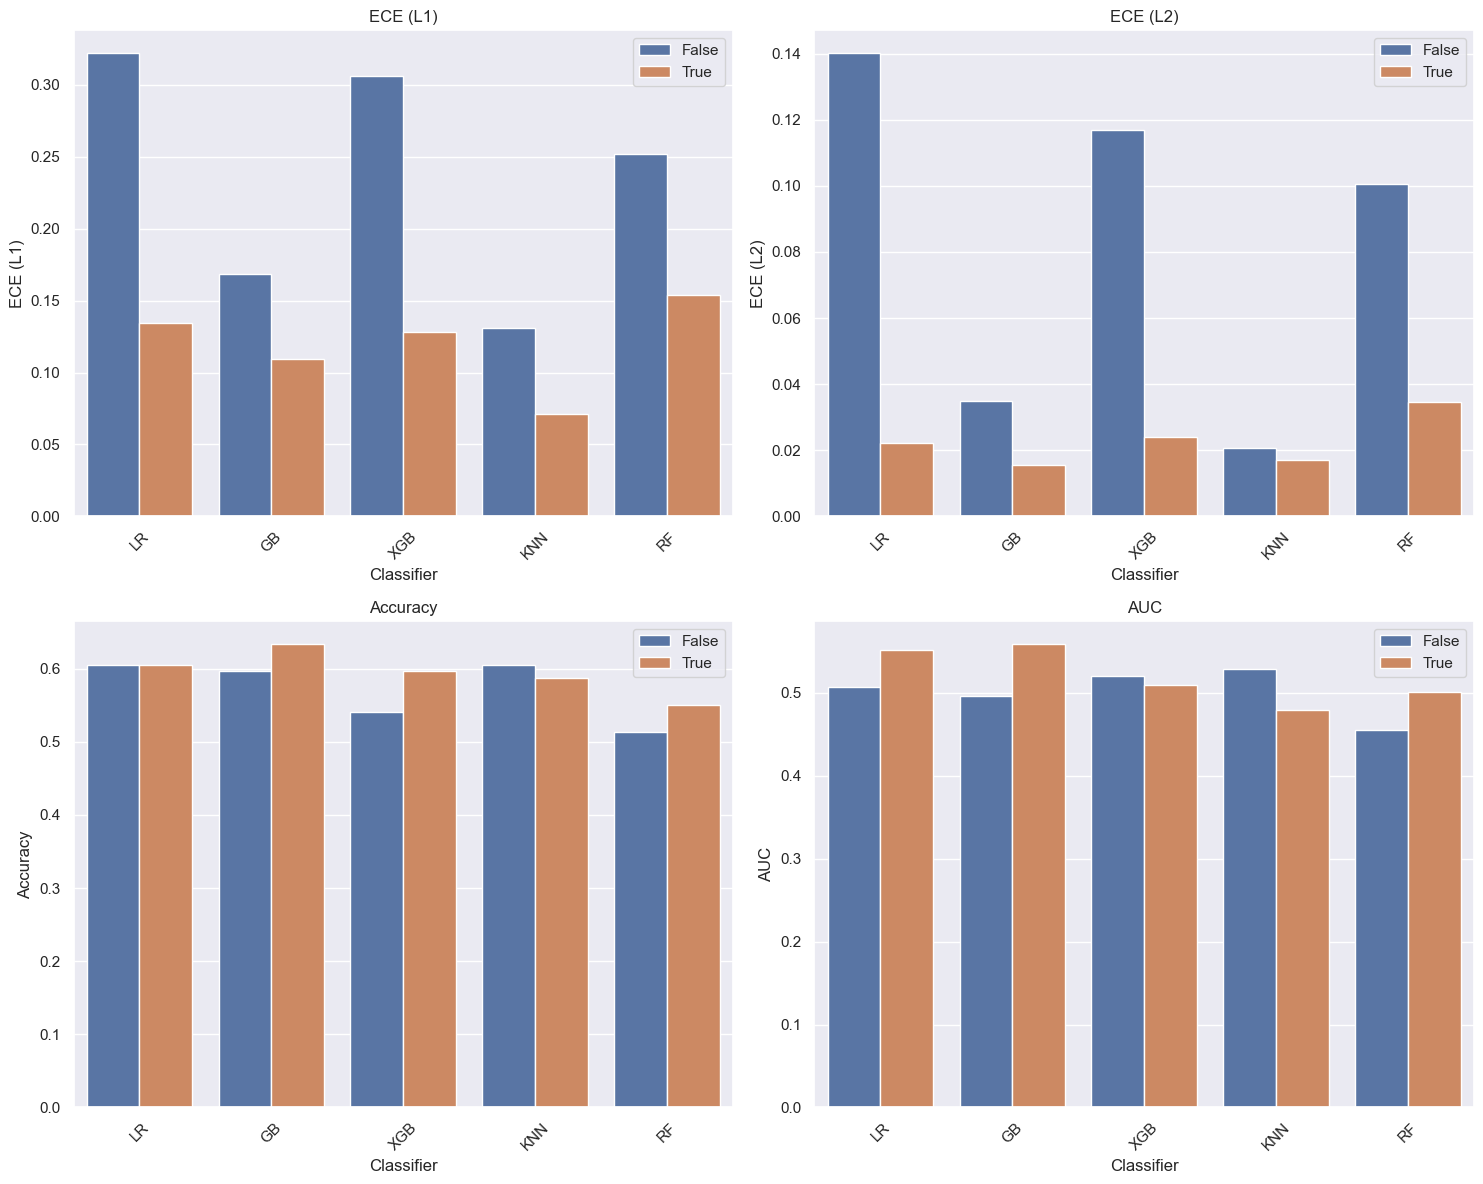

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
metrics = ['ece_l1', 'ece_l2', 'accuracy', 'auc']
titles = ['ECE (L1)', 'ECE (L2)', 'Accuracy', 'AUC']
axes = axes.ravel()

# Create subplots
for idx, (metric, title) in enumerate(zip(metrics, titles)):
    sns.barplot(
        data=training_results_df,
        x='clf',
        y=metric,
        hue='calibrated',
        ax=axes[idx],
    )
    axes[idx].set_title(title)
    axes[idx].set_xlabel('Classifier')
    axes[idx].set_ylabel(title)
    # Rotate x-axis labels for better readability
    axes[idx].tick_params(axis='x', rotation=45)
    # Move legend to a better position
    axes[idx].legend(title='')

# Adjust layout
plt.tight_layout()
plt.show()

### Section 2: Comparing Ski Rental Algorithms

In [22]:
results_df = pd.DataFrame()
bins=20
b=10
num_runs = 1
for i in range(num_runs): 
        i=1
        indices = np.arange(len(movie_df))

        # First split: separate out test set (20% of data)
        idx_temp, idx_test = train_test_split(
            indices, test_size=0.20, random_state=i
        )

        # Second split: split remaining data into train and validation (0.25 = 20% of original 80%)
        idx_train, idx_valid = train_test_split(
            idx_temp, test_size=0.20, random_state=i
        )
        
        # regression 
        X_train = X_post_reg[idx_train]
        X_valid = X_post_reg[idx_valid]
        X_test = X_post_reg[idx_test]
        
        y_train = y[idx_train]
        y_valid = y[idx_valid]
        y_test = y[idx_test]
                        
        reg_model_name = md.get_best_regressor(X_train,
                                               y_train,
                                               X_valid,
                                               y_valid)
        
        model = Pipeline(
            [
                ("scalar", StandardScaler()),
                (reg_model_name, md.reg_dict[reg_model_name]())

            ]
        )
        rf = WrapRegressor(model)
        rf.fit(X_train, y_train)
        rf.calibrate(X_valid, y_valid)
        conf = 0.7
        results_df['delta'] = 1 - conf 
        conf_interval = rf.predict_int(X_test, confidence=conf)
        results_df['reg_sgd_val'] = model.predict(X_test)
        results_df['reg_sgd_conf_low'] = np.maximum(conf_interval[:, 0], 1)
        results_df['reg_sgd_conf_high'] = np.minimum(conf_interval[:, 1], 500)
        results_df['y'] = y_test 

        
        # classification: 
        X_train = X_post_clf[idx_train]
        X_valid = X_post_clf[idx_valid]
        X_test = X_post_clf[idx_test]
        
        y_train = y_train > b
        y_valid = y_valid > b
        y_test = y_test > b
        results_df['y_bin'] = y_test
        
        clf_model_name = md.get_best_classifier(X_train,
                                               y_train,
                                               X_valid,
                                               y_valid)
        curr_clf = md.model_choice(clf_model_name, X_train, y_train)
        curr_clf.fit(X_train, y_train)
        eps = 1 - curr_clf.score(X_train, y_train) 
        results_df['eps'] = eps
        
        probs = curr_clf.predict_proba(X_test)[:, 1]
        calibrator = cal.BinningCalibrator(bins=bins)
        calibrator.calibrate(curr_clf.predict_proba(X_valid)[:, 1], y_valid)
        y_cal_probs = calibrator.transform(probs)
        
        train_probs = calibrator.transform(curr_clf.predict_proba(X_train)[:, 1])
        
        #TODO: is this train set or test set USING TRAIN
        _, _, alpha, _ = ut.expected_calibration_error(prob_true=np.asarray(y_train),
                                                     prob_pred=np.asarray(train_probs),
                                                     num_bins=bins)
        
        results_df['clf_pred'] =  curr_clf.predict(X_test)
        results_df['clf_prob'] = y_cal_probs 
        results_df['alpha'] = alpha
        results_df['b'] = b

best regressor score: 0.010620961710516408
LR 0.5021208907741251
GB 0.5490455991516436
XGB 0.5206786850477201
running model search
KNN 0.5713149522799577
RF 0.5227995758218451
best classifier KNN score: 0.5713149522799577
running model search


In [23]:
results_df['pip_day'] = results_df.apply(
    lambda row: sr.pip_alg(
        u=row['reg_sgd_conf_high'],
        l=row['reg_sgd_conf_high'], 
        delta=row['delta'],
        b=row['b']
    ), 
    axis=1
)

results_df['naive_day'] = results_df.apply(
    lambda row: sr.regular_ski_rental(pred=row['clf_pred'],
                                   eps=row['eps'],
                                   b=row['b'], 
    ), 
    axis=1
)

results_df['cal_day'] = results_df.apply(
    lambda row: sr.cal_ski_rental(pred=row['clf_prob'],
                                   alpha=row['alpha'],
                                   b=row['b'], 
    ), 
    axis=1
)
results_df['pip_CR'] = results_df.apply(
    lambda row: get_CR(
        buy=row['pip_day'],
        y=row['y'],
        b=row['b']
    ), 
    axis=1
)

results_df['naive_CR'] = results_df.apply(
    lambda row: get_CR(
        buy=row['naive_day'],
        y=row['y'],
        b=row['b']
    ), 
    axis=1
)

results_df['cal_CR'] = results_df.apply(
    lambda row: get_CR(
        buy=row['cal_day'],
        y=row['y'],
        b=row['b']
    ), 
    axis=1
)

In [24]:
results_df[['cal_CR', 'pip_CR', 'naive_CR']].mean()

cal_CR      1.431193
pip_CR      1.431193
naive_CR    1.444667
dtype: float64

In [32]:
# validate naive algorithm
results_df[['clf_pred',  'y_bin', 'naive_day', 'naive_CR']].value_counts()

clf_pred  y_bin  naive_day  naive_CR
True      True   5.765153   1.576515    35
          False  5.765153   1.000000    27
False     False  10.000000  1.000000    22
          True   10.000000  2.000000    12
True      False  5.765153   2.627526     6
                            1.751684     2
                            1.970644     2
                            2.252165     2
                            1.576515     1
Name: count, dtype: int64

In [37]:
print("alpha", results_df['alpha'].value_counts())
results_df.groupby(['clf_pred', 'clf_prob', 'y_bin', 'cal_CR', 'cal_day'])['y'].count()

alpha alpha
0.113006    109
Name: count, dtype: int64


clf_pred  clf_prob  y_bin  cal_CR  cal_day
False     0.00      False  1.0     10          9
                    True   2.0     10          5
          0.40      False  1.0     10         13
                    True   2.0     10          7
True      0.25      False  1.0     10          3
                    True   2.0     10          6
          0.50      False  1.0     10         15
                    True   2.0     10         14
          0.60      False  1.0     10         22
                    True   2.0     10         15
Name: y, dtype: int64

In [40]:
print("delta", results_df['delta'].value_counts())
results_df.groupby(['clf_pred', 'y_bin', 'pip_CR', 'pip_day'])['y'].count()

delta Series([], Name: count, dtype: int64)


clf_pred  y_bin  pip_CR  pip_day
False     False  1.0     10         22
          True   2.0     10         12
True      False  1.0     10         40
          True   2.0     10         35
Name: y, dtype: int64